In [1]:
import os
import copy
import pickle
import logging
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from preprocessing import csv2csv
from modeling import init_datasets, train_model, save_model, load_model
from utils import SkidSteerDataset, PriceModel

In [2]:
### Global Parameters
IMAGE_ROOT = "../data/images/"
RAW_FILEPATH = "../data/SkidSteer_2019-08.csv"
SCORE_FILEPATH = "./colorfulness/skid_steer_color_score.csv"
TRAIN_FILEPATH = "./SkidSteer_2019-08_clean_train.csv"
VAL_FILEPATH = "./SkidSteer_2019-08_clean_val.csv"
COLUMN_IDS = [2, 3, 4, 5, 7, 11]
MODEL_ROOT = "../models/"
MODEL_SAVE_NAME = "test"
# MODEL_LOAD_NAME = "2020-03-17T01:31_test"

### Global Toggles
PREPROCESS = True
TRAINING = True

### Model Parameters
RANDOM_SEED = 1
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
MOMENTUM = 0.9
SCHEDULER_STEP_SIZE = round(NUM_EPOCHS / 4)
HIDDEN_UNITS = [32]
FINE_TUNE = 2
TRANSFORM = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
datasets, dataloaders = init_datasets(train_filepath=TRAIN_FILEPATH,
                                          val_filepath=VAL_FILEPATH,
                                          image_root=IMAGE_ROOT,
                                          col_ids=COLUMN_IDS,
                                          transform=TRANSFORM,
                                          batch_size=BATCH_SIZE)

In [4]:
model_load_path = "../models/2020-03-17T01:31_test"
model, all_records, best_records, scaler_dict = load_model(model_load_path=model_load_path)

invTrans = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
])

In [5]:
# cnn -> features
# fc_layers -> regressor

In [6]:
class CamExtractor():
    """Extracts CAM features from the model."""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """Does a forward pass on convolutions, hooks the function at given layer."""
        conv_output = None
        for module_pos, module in self.model.cnn._modules.items():
            x = module(x)  # Forward
            if str(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, image, ftrs):
        """Does a full forward pass on the model."""
        conv_output, x = self.forward_pass_on_convolutions(image)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = torch.cat([x, ftrs], dim=1)
        x = self.model.fc_layers(x)
        return conv_output, x

In [7]:
class GradCam():
    """Produces class (price) activation map."""
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, input_ftrs, target_price=None):
        '''Generate CAM for the inputs.'''
        conv_output, model_output = self.extractor.forward_pass(input_image, input_ftrs)
        if target_price is None:
            target_price = model_output
        target_price_array = torch.FloatTensor(1, 1).zero_()
        target_price_array[0][0] = target_price
        self.model.cnn.zero_grad()
        self.model.fc_layers.zero_grad()

        model_output.backward(gradient=target_price_array, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.numpy()[0]  # (2048, 7, 7)
        weights = np.mean(guided_gradients, axis=(1, 2)).reshape(-1, 1, 1)  # Take averages for each gradient  # (2048, 1, 1)
        features_map = conv_output.data.numpy()[0]  # (2048, 7, 7)

        cam = np.sum(features_map * weights, axis=0) + 1
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        # cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
        #                input_image.shape[3]), Image.ANTIALIAS))/255
        return cam, model_output

In [8]:
def make_CAM_plots(original_image, viz1, original_price, predicted_price):
    invTrans = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
    ])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.1, 5), gridspec_kw={'width_ratios': [5, 5, 0.1]})
    #plt.figure(figsize=(10, 30.2))
    #ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(invTrans(original_image.squeeze()).permute(1, 2, 0))
    ax1.set_title("Original")
    ax1.set_xticks([])
    ax1.set_yticks([])
    #ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(viz1, cmap="RdYlGn")
    ax2.set_title("Attention")
    ax2.set_xticks([])
    ax2.set_yticks([])
#     ax3 = plt.subplot(1, 3, 3)
#     ax3.imshow(viz2, cmap="coolwarm")
#     ax3.set_title("CAM2")
#     ax3.set_xticks([])
#     ax3.set_yticks([])

    #plt.figure(figsize=(10, 0.2))
    #ax = plt.subplot(1, 1, 1)
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm, orientation='vertical')
    fig.suptitle("Real price: %d   ~   Predicted: %.2f" % (original_price, predicted_price), size=16)
    plt.show()
    return None

In [32]:
model, all_records, best_records, scaler_dict = load_model(model_load_path=model_load_path)

next(model.cnn.conv1.parameters()).grad

18
real: -0.28  predicted: -0.25


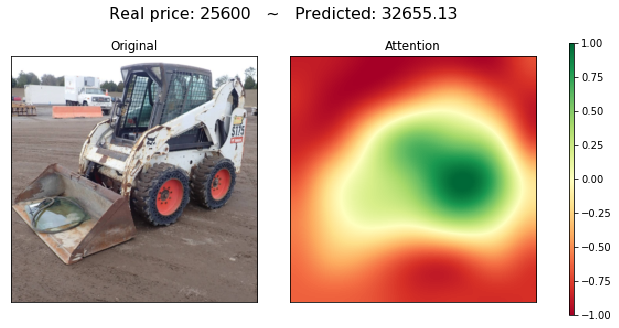

In [33]:
## ii = 159 blue sky

ii = np.random.randint(1000)
ii = 18
price = datasets["val"][ii]["price"]
image = datasets["val"][ii]["image"].unsqueeze(dim=0)
ftrs = datasets["val"][ii]["ftrs"].unsqueeze(dim=0)

gc = GradCam(model, target_layer="layer4")
cam, model_price = gc.generate_cam(image, ftrs, target_price=price)

print(ii)
print("real: %.2f  predicted: %.2f" % (price, model_price))

make_CAM_plots(image, cam, 25600, 32655.12563)

In [16]:
class GuidedBackprop():
    """Produces gradients generated with guided back propagation from the given image."""
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        """
        Updates relu activation functions so that
            1- stores output in forward pass
            2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """If there is a negative gradient, change it to zero."""
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """Store results of forward pass."""
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for module in list(self.model.cnn.modules()):
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, input_ftrs, target_price):
        '''Generate gradients of price with respect to input image.'''
        input_image.requires_grad = True
        model_output = self.model(input_image, input_ftrs)
        self.model.zero_grad()
        target_price_array = torch.FloatTensor(1, 1).zero_()
        target_price_array[0][0] = target_price
        model_output.backward(gradient=target_price_array)
        image_gradients = input_image.grad.squeeze()
        #gradients_as_arr = self.gradients.data.numpy()[0]
        #gradients_as_arr = (gradients_as_arr - gradients_as_arr.min()) / (gradients_as_arr.max() - gradients_as_arr.min())
        # norm1 - [0..1], 1 filter
        image_gradients_norm1 = image_gradients.data.numpy().max(axis=0)
        image_gradients_norm1 = (image_gradients_norm1 - image_gradients_norm1.min()) / (image_gradients_norm1.max() - image_gradients_norm1.min())
        # norm2 - [-1..1], 1 filter
        image_gradients_norm2 = image_gradients.data.numpy().max(axis=0)
        image_gradients_norm2 = image_gradients_norm2*(1/max(image_gradients_norm2.max(), abs(image_gradients_norm2.min())))
        # norm3 - [0..1], 3 filters
        image_gradients_norm3 = image_gradients.data.numpy()
        image_gradients_norm3 = (image_gradients_norm3 - image_gradients_norm3.min()) / (image_gradients_norm3.max() - image_gradients_norm3.min())
        return (image_gradients_norm1, image_gradients_norm2, image_gradients_norm3), model_output

In [38]:
model, all_records, best_records, scaler_dict = load_model(model_load_path=model_load_path)
next(model.cnn.conv1.parameters()).grad

gc = GradCam(copy.deepcopy(model), target_layer="layer4")
gb = GuidedBackprop(copy.deepcopy(model))

787
real: -0.22  predicted: -0.33
tensor([[True]])


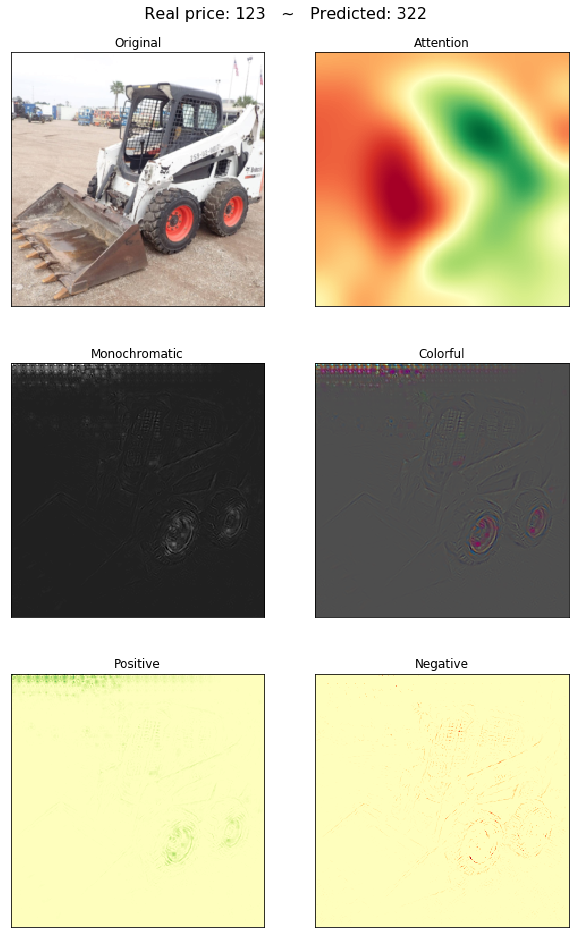

In [57]:
ii = np.random.randint(1000)
# ii = 159
# ii = 885
# ii = 159, 883 # blue sky

price = datasets["val"][ii]["price"]
image = datasets["val"][ii]["image"].unsqueeze(dim=0)
ftrs = datasets["val"][ii]["ftrs"].unsqueeze(dim=0)

# gc = GradCam(copy.deepcopy(model), target_layer="layer4")
cam, model_price1 = gc.generate_cam(image, ftrs, target_price=price)
# gb = GuidedBackprop(copy.deepcopy(model))
guided_grads, model_price2 = gb.generate_gradients(image, ftrs, target_price=price)

print(ii)
print("real: %.2f  predicted: %.2f" % (price, model_price))
print(model_price1 == model_price2)

# plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
(ax1, ax2, ax3, ax4, ax5, ax6) = axs.flatten()
ax1.imshow(invTrans(image.squeeze()).permute(1, 2, 0).data.numpy())
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(cam, cmap="RdYlGn")
ax2.set_title("Attention")
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(guided_grads[0], cmap="gray")
ax3.set_title("Monochromatic")
ax3.set_xticks([])
ax3.set_yticks([])
ax4.imshow(guided_grads[2].transpose(1, 2, 0))
ax4.set_title("Colorful")
ax4.set_xticks([])
ax4.set_yticks([])
ax5.imshow(np.maximum(guided_grads[1], 0), cmap="RdYlGn", vmin=-1, vmax=1)
ax5.set_title("Positive")
ax5.set_xticks([])
ax5.set_yticks([])
ax6.imshow(np.minimum(guided_grads[1], 0), cmap="RdYlGn", vmin=guided_grads[1].min(), vmax=-guided_grads[1].min())
ax6.set_title("Negative")
ax6.set_xticks([])
ax6.set_yticks([])
# fig.tight_layout()
fig.suptitle("  Real price: %d   ~   Predicted: %d" % (123, round(321.65)), size=16)
fig.subplots_adjust(top=0.94)
plt.show()

In [82]:
float(model_price)

-0.32965707778930664

In [84]:
optimizer = optim.SGD(list(model.parameters()), lr=0.1, momentum=0.9)
a = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, verbose=True)
b = lr_scheduler.StepLR(optimizer, step_size=10)

In [92]:
type(a) == lr_scheduler.ReduceLROnPlateau

True

In [86]:
type

In [24]:
class GuidedBackprop2():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = (grad_in[1], grad_out[0])
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        input_image.requires_grad = True
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        print(input_image.grad.shape)
        print(self.gradients[0].shape)
        print(self.gradients[1].shape)
        gradients_as_arr = self.gradients[1].data.numpy()[0]
        return gradients_as_arr, model_output, input_image.grad
    
model2 = models.vgg16(pretrained=True)
model2.eval()
model2(image).argmax()

tensor(864)

In [25]:
gb2 = GuidedBackprop2(model2)
guided_grads, model_price, img_grad = gb2.generate_gradients(image, 864)

torch.Size([1, 3, 224, 224])
torch.Size([64, 3, 3, 3])
torch.Size([1, 64, 224, 224])


2020-03-20 01:23:04,088 WARNING [matplotlib.image] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


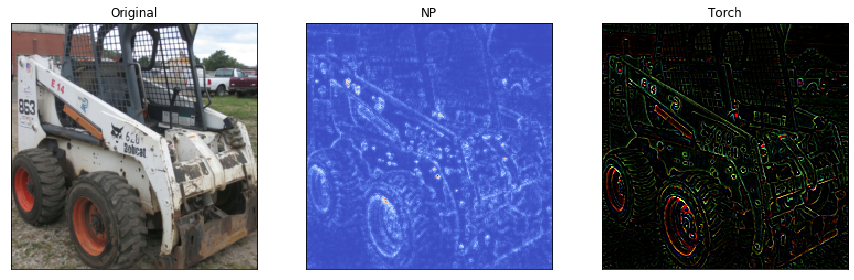

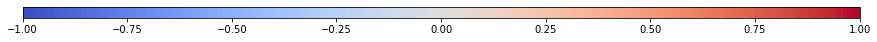

In [41]:
plt.figure(figsize=(15, 45))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(invTrans(image.squeeze()).permute(1, 2, 0).detach().numpy())
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(guided_grads.max(axis=0), cmap="coolwarm")
ax2.set_title("NP")
ax2.set_xticks([])
ax2.set_yticks([])
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(img_grad.squeeze().permute(1, 2, 0), cmap="coolwarm")
ax3.set_title("Torch")
ax3.set_xticks([])
ax3.set_yticks([])

plt.figure(figsize=(15, 0.2))
ax = plt.subplot(1, 1, 1)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
plt.show()

In [160]:
pd.read_csv("../data/SkidSteer_2019-08.csv")["Winning Bid"].str.replace(",", "").astype(float).max()

70000.0

In [136]:
pd.read_csv("SkidSteer_2019-08_clean_val.csv").shape

(1850, 13)

In [137]:
4318 + 1850

6168